## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.4 MB/s eta 0:00:00


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('CTLT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1114,2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
1115,2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
1116,2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500
1117,2023-06-09,39.250000,40.110001,38.480000,38.810001,38.810001,4493800


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 7:1:2
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [12]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [13]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  train_windows, train_targets = create_dataset(train_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)
  test_windows, test_targets = create_dataset(test_data, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [14]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-14 13:21:25,650] A new study created in memory with name: no-name-35bf13c6-cb4b-469e-9c80-d021e86882f9


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 13:22:11,579] Trial 0 finished with value: 292.26142082047147 and parameters: {'window_size': 91, 'tcn_filters': 113, 'tcn_kernel_size': 3, 'dropout_rate': 0.33018498885998404, 'attention_dim': 16}. Best is trial 0 with value: 292.26142082047147.


4/4 [==============================] - 0s 10ms/step


[I 2023-06-14 13:22:25,253] Trial 1 finished with value: 343.7236468218162 and parameters: {'window_size': 97, 'tcn_filters': 100, 'tcn_kernel_size': 3, 'dropout_rate': 0.3174024222821119, 'attention_dim': 19}. Best is trial 0 with value: 292.26142082047147.


4/4 [==============================] - 0s 8ms/step


[I 2023-06-14 13:22:37,289] Trial 2 finished with value: 315.41860487724625 and parameters: {'window_size': 97, 'tcn_filters': 68, 'tcn_kernel_size': 3, 'dropout_rate': 0.37779343912489627, 'attention_dim': 16}. Best is trial 0 with value: 292.26142082047147.


5/5 [==============================] - 0s 24ms/step


[I 2023-06-14 13:22:59,818] Trial 3 finished with value: 550.5488834349431 and parameters: {'window_size': 84, 'tcn_filters': 126, 'tcn_kernel_size': 5, 'dropout_rate': 0.10626909190661667, 'attention_dim': 9}. Best is trial 0 with value: 292.26142082047147.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 13:23:12,840] Trial 4 finished with value: 211.75773210456882 and parameters: {'window_size': 50, 'tcn_filters': 45, 'tcn_kernel_size': 3, 'dropout_rate': 0.19859258073258937, 'attention_dim': 12}. Best is trial 4 with value: 211.75773210456882.


5/5 [==============================] - 1s 12ms/step


[I 2023-06-14 13:23:23,449] Trial 5 finished with value: 563.8121547960881 and parameters: {'window_size': 74, 'tcn_filters': 121, 'tcn_kernel_size': 2, 'dropout_rate': 0.2283351430919158, 'attention_dim': 9}. Best is trial 4 with value: 211.75773210456882.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 13:23:35,674] Trial 6 finished with value: 610.2696334599639 and parameters: {'window_size': 95, 'tcn_filters': 95, 'tcn_kernel_size': 2, 'dropout_rate': 0.2763034426027833, 'attention_dim': 29}. Best is trial 4 with value: 211.75773210456882.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 13:23:47,828] Trial 7 finished with value: 198.10551532089397 and parameters: {'window_size': 55, 'tcn_filters': 80, 'tcn_kernel_size': 4, 'dropout_rate': 0.20532994229777396, 'attention_dim': 9}. Best is trial 7 with value: 198.10551532089397.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 13:24:00,136] Trial 8 finished with value: 271.38400832968216 and parameters: {'window_size': 66, 'tcn_filters': 96, 'tcn_kernel_size': 2, 'dropout_rate': 0.39286901989127687, 'attention_dim': 30}. Best is trial 7 with value: 198.10551532089397.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 13:24:07,922] Trial 9 finished with value: 368.52719221480345 and parameters: {'window_size': 74, 'tcn_filters': 84, 'tcn_kernel_size': 3, 'dropout_rate': 0.32483438842476653, 'attention_dim': 17}. Best is trial 7 with value: 198.10551532089397.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:24:16,867] Trial 10 finished with value: 58.470643332227745 and parameters: {'window_size': 22, 'tcn_filters': 59, 'tcn_kernel_size': 5, 'dropout_rate': 0.44385585324995563, 'attention_dim': 25}. Best is trial 10 with value: 58.470643332227745.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:24:20,917] Trial 11 finished with value: 84.60406154251073 and parameters: {'window_size': 19, 'tcn_filters': 58, 'tcn_kernel_size': 5, 'dropout_rate': 0.4888600460546493, 'attention_dim': 25}. Best is trial 10 with value: 58.470643332227745.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 13:24:25,433] Trial 12 finished with value: 69.79917099873268 and parameters: {'window_size': 21, 'tcn_filters': 53, 'tcn_kernel_size': 5, 'dropout_rate': 0.48038649285795026, 'attention_dim': 24}. Best is trial 10 with value: 58.470643332227745.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:24:30,368] Trial 13 finished with value: 72.07651303320091 and parameters: {'window_size': 10, 'tcn_filters': 35, 'tcn_kernel_size': 5, 'dropout_rate': 0.4917909451233118, 'attention_dim': 24}. Best is trial 10 with value: 58.470643332227745.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:24:37,641] Trial 14 finished with value: 133.26464022390957 and parameters: {'window_size': 32, 'tcn_filters': 55, 'tcn_kernel_size': 4, 'dropout_rate': 0.4324643172827528, 'attention_dim': 24}. Best is trial 10 with value: 58.470643332227745.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 13:24:45,782] Trial 15 finished with value: 149.35977949264037 and parameters: {'window_size': 34, 'tcn_filters': 67, 'tcn_kernel_size': 4, 'dropout_rate': 0.4450721140408062, 'attention_dim': 27}. Best is trial 10 with value: 58.470643332227745.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 13:24:50,250] Trial 16 finished with value: 214.93344014724264 and parameters: {'window_size': 36, 'tcn_filters': 32, 'tcn_kernel_size': 5, 'dropout_rate': 0.49681297853498174, 'attention_dim': 32}. Best is trial 10 with value: 58.470643332227745.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:24:54,744] Trial 17 finished with value: 71.10707514761226 and parameters: {'window_size': 23, 'tcn_filters': 48, 'tcn_kernel_size': 4, 'dropout_rate': 0.44934295361517523, 'attention_dim': 21}. Best is trial 10 with value: 58.470643332227745.


6/6 [==============================] - 0s 12ms/step


[I 2023-06-14 13:25:07,831] Trial 18 finished with value: 127.1820237117615 and parameters: {'window_size': 45, 'tcn_filters': 68, 'tcn_kernel_size': 5, 'dropout_rate': 0.3768290927170635, 'attention_dim': 21}. Best is trial 10 with value: 58.470643332227745.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:25:12,389] Trial 19 finished with value: 51.556936180443614 and parameters: {'window_size': 11, 'tcn_filters': 43, 'tcn_kernel_size': 5, 'dropout_rate': 0.42928041059973815, 'attention_dim': 26}. Best is trial 19 with value: 51.556936180443614.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:25:16,275] Trial 20 finished with value: 52.04541165115336 and parameters: {'window_size': 10, 'tcn_filters': 41, 'tcn_kernel_size': 4, 'dropout_rate': 0.40946405259876295, 'attention_dim': 27}. Best is trial 19 with value: 51.556936180443614.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:25:21,606] Trial 21 finished with value: 55.92252824993424 and parameters: {'window_size': 11, 'tcn_filters': 43, 'tcn_kernel_size': 4, 'dropout_rate': 0.40681326086710323, 'attention_dim': 28}. Best is trial 19 with value: 51.556936180443614.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:25:27,408] Trial 22 finished with value: 68.39219824911515 and parameters: {'window_size': 11, 'tcn_filters': 41, 'tcn_kernel_size': 4, 'dropout_rate': 0.3948574589231377, 'attention_dim': 28}. Best is trial 19 with value: 51.556936180443614.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:25:30,784] Trial 23 finished with value: 52.98182889341446 and parameters: {'window_size': 10, 'tcn_filters': 42, 'tcn_kernel_size': 4, 'dropout_rate': 0.41377613915393263, 'attention_dim': 30}. Best is trial 19 with value: 51.556936180443614.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:25:37,878] Trial 24 finished with value: 50.97994149915985 and parameters: {'window_size': 29, 'tcn_filters': 37, 'tcn_kernel_size': 4, 'dropout_rate': 0.3487032914823207, 'attention_dim': 32}. Best is trial 24 with value: 50.97994149915985.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:25:45,467] Trial 25 finished with value: 80.80597928043979 and parameters: {'window_size': 28, 'tcn_filters': 36, 'tcn_kernel_size': 4, 'dropout_rate': 0.355851962770919, 'attention_dim': 31}. Best is trial 24 with value: 50.97994149915985.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 13:25:57,655] Trial 26 finished with value: 303.43611924141015 and parameters: {'window_size': 41, 'tcn_filters': 50, 'tcn_kernel_size': 4, 'dropout_rate': 0.35693901421711377, 'attention_dim': 32}. Best is trial 24 with value: 50.97994149915985.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 13:26:06,953] Trial 27 finished with value: 51.56760437203014 and parameters: {'window_size': 17, 'tcn_filters': 62, 'tcn_kernel_size': 5, 'dropout_rate': 0.4122769059142329, 'attention_dim': 26}. Best is trial 24 with value: 50.97994149915985.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:26:12,877] Trial 28 finished with value: 140.97603099705748 and parameters: {'window_size': 27, 'tcn_filters': 61, 'tcn_kernel_size': 5, 'dropout_rate': 0.35491154542782, 'attention_dim': 22}. Best is trial 24 with value: 50.97994149915985.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 13:26:21,026] Trial 29 finished with value: 185.91167539821248 and parameters: {'window_size': 17, 'tcn_filters': 74, 'tcn_kernel_size': 5, 'dropout_rate': 0.46636070438140353, 'attention_dim': 19}. Best is trial 24 with value: 50.97994149915985.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 13:26:33,644] Trial 30 finished with value: 263.73064274601757 and parameters: {'window_size': 59, 'tcn_filters': 50, 'tcn_kernel_size': 5, 'dropout_rate': 0.42989930598620546, 'attention_dim': 26}. Best is trial 24 with value: 50.97994149915985.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:26:38,415] Trial 31 finished with value: 107.51475215017916 and parameters: {'window_size': 16, 'tcn_filters': 39, 'tcn_kernel_size': 4, 'dropout_rate': 0.41184800331480914, 'attention_dim': 28}. Best is trial 24 with value: 50.97994149915985.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:26:41,562] Trial 32 finished with value: 79.80801571278502 and parameters: {'window_size': 17, 'tcn_filters': 35, 'tcn_kernel_size': 3, 'dropout_rate': 0.4209959356254356, 'attention_dim': 26}. Best is trial 24 with value: 50.97994149915985.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 13:26:53,700] Trial 33 finished with value: 86.90750049342607 and parameters: {'window_size': 27, 'tcn_filters': 62, 'tcn_kernel_size': 5, 'dropout_rate': 0.4583443666520159, 'attention_dim': 23}. Best is trial 24 with value: 50.97994149915985.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 13:27:00,935] Trial 34 finished with value: 107.29854685189258 and parameters: {'window_size': 16, 'tcn_filters': 47, 'tcn_kernel_size': 4, 'dropout_rate': 0.37956308820470314, 'attention_dim': 30}. Best is trial 24 with value: 50.97994149915985.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 13:27:14,061] Trial 35 finished with value: 100.67790256009609 and parameters: {'window_size': 41, 'tcn_filters': 73, 'tcn_kernel_size': 3, 'dropout_rate': 0.34021251801157293, 'attention_dim': 27}. Best is trial 24 with value: 50.97994149915985.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:27:21,775] Trial 36 finished with value: 128.26468142985675 and parameters: {'window_size': 24, 'tcn_filters': 32, 'tcn_kernel_size': 5, 'dropout_rate': 0.29790153388337104, 'attention_dim': 17}. Best is trial 24 with value: 50.97994149915985.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:27:26,587] Trial 37 finished with value: 63.93154324309256 and parameters: {'window_size': 14, 'tcn_filters': 55, 'tcn_kernel_size': 3, 'dropout_rate': 0.3872492675053398, 'attention_dim': 13}. Best is trial 24 with value: 50.97994149915985.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:27:33,954] Trial 38 finished with value: 135.74713379073503 and parameters: {'window_size': 31, 'tcn_filters': 45, 'tcn_kernel_size': 4, 'dropout_rate': 0.4717899838727362, 'attention_dim': 29}. Best is trial 24 with value: 50.97994149915985.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 13:27:41,360] Trial 39 finished with value: 49.23668103041834 and parameters: {'window_size': 20, 'tcn_filters': 89, 'tcn_kernel_size': 5, 'dropout_rate': 0.4237351765703447, 'attention_dim': 32}. Best is trial 39 with value: 49.23668103041834.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 13:27:49,860] Trial 40 finished with value: 237.62544744336668 and parameters: {'window_size': 41, 'tcn_filters': 88, 'tcn_kernel_size': 5, 'dropout_rate': 0.43911430767873993, 'attention_dim': 32}. Best is trial 39 with value: 49.23668103041834.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 13:28:02,008] Trial 41 finished with value: 53.862562728580585 and parameters: {'window_size': 21, 'tcn_filters': 101, 'tcn_kernel_size': 5, 'dropout_rate': 0.4034508457997648, 'attention_dim': 31}. Best is trial 39 with value: 49.23668103041834.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 13:28:20,615] Trial 42 finished with value: 207.8922932675098 and parameters: {'window_size': 87, 'tcn_filters': 108, 'tcn_kernel_size': 5, 'dropout_rate': 0.4222322077579277, 'attention_dim': 29}. Best is trial 39 with value: 49.23668103041834.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 13:28:27,575] Trial 43 finished with value: 164.45169380282653 and parameters: {'window_size': 15, 'tcn_filters': 91, 'tcn_kernel_size': 5, 'dropout_rate': 0.45834815357250913, 'attention_dim': 26}. Best is trial 39 with value: 49.23668103041834.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 13:28:34,451] Trial 44 finished with value: 113.84695352890704 and parameters: {'window_size': 26, 'tcn_filters': 81, 'tcn_kernel_size': 5, 'dropout_rate': 0.3736273248012547, 'attention_dim': 31}. Best is trial 39 with value: 49.23668103041834.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:28:47,621] Trial 45 finished with value: 57.99505949487892 and parameters: {'window_size': 20, 'tcn_filters': 104, 'tcn_kernel_size': 2, 'dropout_rate': 0.3945916855519435, 'attention_dim': 27}. Best is trial 39 with value: 49.23668103041834.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:28:52,183] Trial 46 finished with value: 48.928642757661365 and parameters: {'window_size': 13, 'tcn_filters': 73, 'tcn_kernel_size': 4, 'dropout_rate': 0.42612563850277885, 'attention_dim': 23}. Best is trial 46 with value: 48.928642757661365.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 13:28:59,022] Trial 47 finished with value: 143.6018424921013 and parameters: {'window_size': 36, 'tcn_filters': 74, 'tcn_kernel_size': 5, 'dropout_rate': 0.46597549105832, 'attention_dim': 23}. Best is trial 46 with value: 48.928642757661365.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 13:29:06,042] Trial 48 finished with value: 68.95464338424502 and parameters: {'window_size': 31, 'tcn_filters': 86, 'tcn_kernel_size': 4, 'dropout_rate': 0.43715964397523893, 'attention_dim': 19}. Best is trial 46 with value: 48.928642757661365.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 13:29:18,201] Trial 49 finished with value: 257.44091322542 and parameters: {'window_size': 76, 'tcn_filters': 66, 'tcn_kernel_size': 3, 'dropout_rate': 0.30902369450448175, 'attention_dim': 25}. Best is trial 46 with value: 48.928642757661365.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-14 13:29:24,876] Trial 50 finished with value: 94.8876314793395 and parameters: {'window_size': 20, 'tcn_filters': 119, 'tcn_kernel_size': 5, 'dropout_rate': 0.43129639001533726, 'attention_dim': 21}. Best is trial 46 with value: 48.928642757661365.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:29:30,281] Trial 51 finished with value: 71.95510064456093 and parameters: {'window_size': 14, 'tcn_filters': 78, 'tcn_kernel_size': 4, 'dropout_rate': 0.40789539445734785, 'attention_dim': 23}. Best is trial 46 with value: 48.928642757661365.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:29:35,885] Trial 52 finished with value: 60.990663456170054 and parameters: {'window_size': 13, 'tcn_filters': 92, 'tcn_kernel_size': 4, 'dropout_rate': 0.41934940053626096, 'attention_dim': 25}. Best is trial 46 with value: 48.928642757661365.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:29:41,679] Trial 53 finished with value: 72.86990123137595 and parameters: {'window_size': 10, 'tcn_filters': 52, 'tcn_kernel_size': 4, 'dropout_rate': 0.4492315542282549, 'attention_dim': 29}. Best is trial 46 with value: 48.928642757661365.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:29:48,928] Trial 54 finished with value: 63.05021503345464 and parameters: {'window_size': 24, 'tcn_filters': 64, 'tcn_kernel_size': 4, 'dropout_rate': 0.4818948555261449, 'attention_dim': 24}. Best is trial 46 with value: 48.928642757661365.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:29:56,622] Trial 55 finished with value: 127.27041561649787 and parameters: {'window_size': 19, 'tcn_filters': 38, 'tcn_kernel_size': 5, 'dropout_rate': 0.3959633535802568, 'attention_dim': 28}. Best is trial 46 with value: 48.928642757661365.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:30:01,130] Trial 56 finished with value: 46.62067422311439 and parameters: {'window_size': 13, 'tcn_filters': 56, 'tcn_kernel_size': 4, 'dropout_rate': 0.3704594339834086, 'attention_dim': 27}. Best is trial 56 with value: 46.62067422311439.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:30:12,234] Trial 57 finished with value: 110.96100772033317 and parameters: {'window_size': 23, 'tcn_filters': 57, 'tcn_kernel_size': 5, 'dropout_rate': 0.368089938383202, 'attention_dim': 30}. Best is trial 56 with value: 46.62067422311439.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 13:30:21,266] Trial 58 finished with value: 177.48344364869928 and parameters: {'window_size': 51, 'tcn_filters': 71, 'tcn_kernel_size': 4, 'dropout_rate': 0.39021338995565896, 'attention_dim': 20}. Best is trial 56 with value: 46.62067422311439.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:30:29,768] Trial 59 finished with value: 56.97527412892769 and parameters: {'window_size': 18, 'tcn_filters': 77, 'tcn_kernel_size': 3, 'dropout_rate': 0.3271646972998941, 'attention_dim': 22}. Best is trial 56 with value: 46.62067422311439.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 13:30:36,913] Trial 60 finished with value: 95.50623103505596 and parameters: {'window_size': 13, 'tcn_filters': 82, 'tcn_kernel_size': 4, 'dropout_rate': 0.3671486468143681, 'attention_dim': 31}. Best is trial 56 with value: 46.62067422311439.


7/7 [==============================] - 1s 3ms/step


[I 2023-06-14 13:30:42,489] Trial 61 finished with value: 50.56842472225138 and parameters: {'window_size': 10, 'tcn_filters': 45, 'tcn_kernel_size': 4, 'dropout_rate': 0.4021470535192708, 'attention_dim': 27}. Best is trial 56 with value: 46.62067422311439.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:30:47,470] Trial 62 finished with value: 40.111311066914155 and parameters: {'window_size': 14, 'tcn_filters': 45, 'tcn_kernel_size': 4, 'dropout_rate': 0.3838848902409361, 'attention_dim': 26}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 13:30:52,761] Trial 63 finished with value: 46.56764245494699 and parameters: {'window_size': 13, 'tcn_filters': 45, 'tcn_kernel_size': 4, 'dropout_rate': 0.38327219566847154, 'attention_dim': 25}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:30:57,462] Trial 64 finished with value: 52.47027166494458 and parameters: {'window_size': 13, 'tcn_filters': 46, 'tcn_kernel_size': 4, 'dropout_rate': 0.339482660391214, 'attention_dim': 24}. Best is trial 62 with value: 40.111311066914155.


4/4 [==============================] - 0s 10ms/step


[I 2023-06-14 13:31:07,403] Trial 65 finished with value: 292.6565905136151 and parameters: {'window_size': 100, 'tcn_filters': 52, 'tcn_kernel_size': 4, 'dropout_rate': 0.38019256336067025, 'attention_dim': 25}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:31:12,040] Trial 66 finished with value: 209.82649866846586 and parameters: {'window_size': 22, 'tcn_filters': 48, 'tcn_kernel_size': 4, 'dropout_rate': 0.35938995918577055, 'attention_dim': 29}. Best is trial 62 with value: 40.111311066914155.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 13:31:19,204] Trial 67 finished with value: 341.7242717628856 and parameters: {'window_size': 64, 'tcn_filters': 38, 'tcn_kernel_size': 4, 'dropout_rate': 0.3828584303563891, 'attention_dim': 27}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:31:26,888] Trial 68 finished with value: 57.1321454329091 and parameters: {'window_size': 19, 'tcn_filters': 43, 'tcn_kernel_size': 4, 'dropout_rate': 0.3475641703397183, 'attention_dim': 8}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 13:31:31,487] Trial 69 finished with value: 208.8428433844464 and parameters: {'window_size': 13, 'tcn_filters': 55, 'tcn_kernel_size': 4, 'dropout_rate': 0.37314295340589415, 'attention_dim': 22}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:31:40,668] Trial 70 finished with value: 57.009067634413725 and parameters: {'window_size': 25, 'tcn_filters': 50, 'tcn_kernel_size': 4, 'dropout_rate': 0.36300458827896104, 'attention_dim': 32}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:31:43,967] Trial 71 finished with value: 57.680629687221035 and parameters: {'window_size': 10, 'tcn_filters': 35, 'tcn_kernel_size': 4, 'dropout_rate': 0.39958230748031254, 'attention_dim': 26}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:31:49,544] Trial 72 finished with value: 54.08968348673248 and parameters: {'window_size': 15, 'tcn_filters': 44, 'tcn_kernel_size': 4, 'dropout_rate': 0.38797136864386206, 'attention_dim': 28}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:31:54,372] Trial 73 finished with value: 74.48553866577174 and parameters: {'window_size': 12, 'tcn_filters': 41, 'tcn_kernel_size': 4, 'dropout_rate': 0.4268174510705542, 'attention_dim': 27}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:31:58,568] Trial 74 finished with value: 55.84456873180972 and parameters: {'window_size': 17, 'tcn_filters': 39, 'tcn_kernel_size': 4, 'dropout_rate': 0.416486904886162, 'attention_dim': 24}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:32:10,953] Trial 75 finished with value: 85.90001092872637 and parameters: {'window_size': 28, 'tcn_filters': 59, 'tcn_kernel_size': 3, 'dropout_rate': 0.44175231291251144, 'attention_dim': 26}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:32:14,821] Trial 76 finished with value: 48.069616581316325 and parameters: {'window_size': 10, 'tcn_filters': 34, 'tcn_kernel_size': 2, 'dropout_rate': 0.4056059352007529, 'attention_dim': 25}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:32:20,041] Trial 77 finished with value: 48.74096338897306 and parameters: {'window_size': 16, 'tcn_filters': 33, 'tcn_kernel_size': 2, 'dropout_rate': 0.4020885148641884, 'attention_dim': 23}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:32:25,269] Trial 78 finished with value: 56.70117499870449 and parameters: {'window_size': 15, 'tcn_filters': 48, 'tcn_kernel_size': 2, 'dropout_rate': 0.40307190771161105, 'attention_dim': 23}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:32:28,683] Trial 79 finished with value: 70.86776082686205 and parameters: {'window_size': 22, 'tcn_filters': 34, 'tcn_kernel_size': 2, 'dropout_rate': 0.40322066340233215, 'attention_dim': 25}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:32:33,082] Trial 80 finished with value: 47.70557826880169 and parameters: {'window_size': 10, 'tcn_filters': 32, 'tcn_kernel_size': 2, 'dropout_rate': 0.4196863738248013, 'attention_dim': 21}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:32:37,430] Trial 81 finished with value: 79.75397954557391 and parameters: {'window_size': 10, 'tcn_filters': 33, 'tcn_kernel_size': 2, 'dropout_rate': 0.42373123722932615, 'attention_dim': 20}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 13:32:40,661] Trial 82 finished with value: 68.33703241806246 and parameters: {'window_size': 17, 'tcn_filters': 32, 'tcn_kernel_size': 2, 'dropout_rate': 0.3865759674337038, 'attention_dim': 21}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 13:32:45,325] Trial 83 finished with value: 48.144533094374744 and parameters: {'window_size': 12, 'tcn_filters': 40, 'tcn_kernel_size': 2, 'dropout_rate': 0.4094692642328951, 'attention_dim': 18}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:32:48,686] Trial 84 finished with value: 42.28672857880779 and parameters: {'window_size': 12, 'tcn_filters': 40, 'tcn_kernel_size': 2, 'dropout_rate': 0.4316199428807495, 'attention_dim': 16}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:32:53,107] Trial 85 finished with value: 72.91796984884888 and parameters: {'window_size': 13, 'tcn_filters': 40, 'tcn_kernel_size': 2, 'dropout_rate': 0.41314340160451396, 'attention_dim': 12}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 1s 4ms/step


[I 2023-06-14 13:32:57,338] Trial 86 finished with value: 52.15789792611728 and parameters: {'window_size': 12, 'tcn_filters': 36, 'tcn_kernel_size': 2, 'dropout_rate': 0.44066748382334, 'attention_dim': 16}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:33:05,461] Trial 87 finished with value: 53.16515224302 and parameters: {'window_size': 16, 'tcn_filters': 36, 'tcn_kernel_size': 2, 'dropout_rate': 0.43321657558163645, 'attention_dim': 18}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:33:10,279] Trial 88 finished with value: 57.03380573647148 and parameters: {'window_size': 15, 'tcn_filters': 42, 'tcn_kernel_size': 2, 'dropout_rate': 0.37867970837430553, 'attention_dim': 15}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:33:16,410] Trial 89 finished with value: 72.81360618873575 and parameters: {'window_size': 18, 'tcn_filters': 32, 'tcn_kernel_size': 2, 'dropout_rate': 0.41280319083073047, 'attention_dim': 15}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:33:19,624] Trial 90 finished with value: 71.50087737669055 and parameters: {'window_size': 12, 'tcn_filters': 37, 'tcn_kernel_size': 2, 'dropout_rate': 0.45226580540134376, 'attention_dim': 18}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:33:23,662] Trial 91 finished with value: 85.906332669575 and parameters: {'window_size': 19, 'tcn_filters': 40, 'tcn_kernel_size': 2, 'dropout_rate': 0.4229500746461533, 'attention_dim': 22}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:33:30,906] Trial 92 finished with value: 90.72364385447915 and parameters: {'window_size': 21, 'tcn_filters': 34, 'tcn_kernel_size': 2, 'dropout_rate': 0.4303353098426439, 'attention_dim': 19}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:33:37,741] Trial 93 finished with value: 113.2150149877506 and parameters: {'window_size': 15, 'tcn_filters': 95, 'tcn_kernel_size': 2, 'dropout_rate': 0.3953900602689714, 'attention_dim': 16}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 13:33:42,456] Trial 94 finished with value: 59.104815548209544 and parameters: {'window_size': 12, 'tcn_filters': 38, 'tcn_kernel_size': 3, 'dropout_rate': 0.4158648545184935, 'attention_dim': 24}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:33:47,630] Trial 95 finished with value: 54.678758715399624 and parameters: {'window_size': 10, 'tcn_filters': 43, 'tcn_kernel_size': 2, 'dropout_rate': 0.40717952088204884, 'attention_dim': 21}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:33:54,880] Trial 96 finished with value: 41.50310267465768 and parameters: {'window_size': 17, 'tcn_filters': 85, 'tcn_kernel_size': 2, 'dropout_rate': 0.4472657530760159, 'attention_dim': 17}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:33:59,064] Trial 97 finished with value: 59.28804427719872 and parameters: {'window_size': 17, 'tcn_filters': 46, 'tcn_kernel_size': 2, 'dropout_rate': 0.44682389096500896, 'attention_dim': 17}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 13:34:04,706] Trial 98 finished with value: 72.07721868675767 and parameters: {'window_size': 14, 'tcn_filters': 85, 'tcn_kernel_size': 2, 'dropout_rate': 0.43490386198056996, 'attention_dim': 18}. Best is trial 62 with value: 40.111311066914155.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 13:34:09,297] Trial 99 finished with value: 45.2481047196315 and parameters: {'window_size': 12, 'tcn_filters': 70, 'tcn_kernel_size': 2, 'dropout_rate': 0.457626590774595, 'attention_dim': 17}. Best is trial 62 with value: 40.111311066914155.


In [15]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 14, 'tcn_filters': 45, 'tcn_kernel_size': 4, 'dropout_rate': 0.3838848902409361, 'attention_dim': 26}


In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.09206451432922337
RMSE on Test dataset:  6.333349119298111
MSLE on Test dataset:  0.014883675815589201


### Save and Load the best model and related information

In [17]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_msle.npy', best_msle)

In [18]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_msle.npy').item()

## Predicting the next 30 days

### Preparing the forecast date index

In [19]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [20]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-loaded_best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 26ms/step


In [21]:
print('Predicted closing prices for the next 30 days:')
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[43.614147 44.201096 44.442284 44.639713 44.791027 44.92887  45.029408
 45.103985 45.1586   45.199757 45.231243 45.25517  45.273697 45.287865
 45.298775 45.307358 45.31403  45.31922  45.323246 45.326363 45.328785
 45.33067  45.33214  45.333294 45.33419  45.33489  45.335438 45.335857
 45.33619  45.336445]


## Visualization

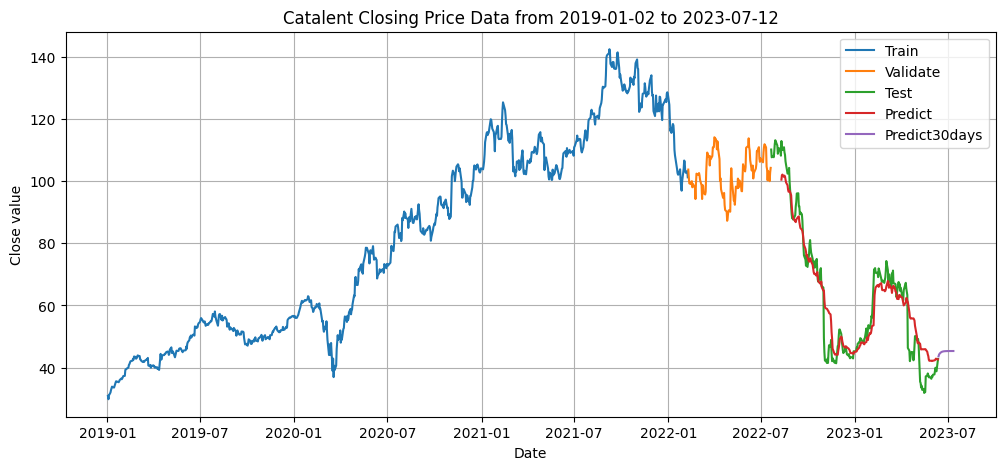

In [22]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + loaded_best_window_size: ], loaded_best_y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])

plt.grid()
plt.title(f"Catalent Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_712_CTLT.png')
plt.show()